In [56]:

from pyspark.sql import SparkSession
from ucimlrepo import fetch_ucirepo
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
spark = SparkSession.builder.appName("Jupyter").getOrCreate()

spark

25/05/10 18:03:12 WARN Utils: Your hostname, JordansGaming resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/10 18:03:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 18:03:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [4]:
spark_df = spark.createDataFrame(X)


spark_df.show()

25/05/10 18:06:40 WARN TaskSetManager: Stage 0 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------+--------------+---------+----------+--------------+
|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+--------------------+--------+--------------+---------+----------+--------------+
|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|   17850.0|United Kingdom|
| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|   17850.0|United Kingdom|
|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|   17850.0|United Kingdom|
|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.25|   17850.0|United Kingdom|
|HAND WARMER UNION...|       6|12/1/2010 8:28|     1.85|   17850.0|United Kingdom|
|HAND WARMER RED P...|       6|12/1/2010 8:28|     1.85|   17850.0|United Kingdom|
|ASS

In [33]:
spark_df.printSchema()

root
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- total_price: double (nullable = true)



In [34]:
spark_df.distinct().count()

25/05/10 18:40:19 WARN TaskSetManager: Stage 46 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


535902

In [40]:
spark_df.dropna().count()

25/05/10 18:41:50 WARN TaskSetManager: Stage 64 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


406829

## Show all Countries in column

In [41]:
spark_df.select(spark_df.Country).distinct().show()

25/05/10 18:42:01 WARN TaskSetManager: Stage 67 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+---------------+
|        Country|
+---------------+
|         Sweden|
|        Germany|
|         France|
|        Belgium|
|        Finland|
|          Italy|
|           EIRE|
|      Lithuania|
|         Norway|
|          Spain|
|        Denmark|
|        Iceland|
|         Israel|
|Channel Islands|
|         Cyprus|
|    Switzerland|
|          Japan|
|         Poland|
|       Portugal|
|      Australia|
+---------------+
only showing top 20 rows



## Show Total Sales group by country

In [42]:
# Create Total Price column


spark_df = spark_df.withColumn("total_price", spark_df.UnitPrice * spark_df.Quantity)


In [43]:

# Show Total Sales by country
spark_df.groupBy("Country").count().sort("count", ascending=False).show()

25/05/10 18:42:11 WARN TaskSetManager: Stage 70 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|495478|
|        Germany|  9495|
|         France|  8557|
|           EIRE|  8196|
|          Spain|  2533|
|    Netherlands|  2371|
|        Belgium|  2069|
|    Switzerland|  2002|
|       Portugal|  1519|
|      Australia|  1259|
|         Norway|  1086|
|          Italy|   803|
|Channel Islands|   758|
|        Finland|   695|
|         Cyprus|   622|
|         Sweden|   462|
|    Unspecified|   446|
|        Austria|   401|
|        Denmark|   389|
|          Japan|   358|
+---------------+------+
only showing top 20 rows



In [44]:

# Show Total Sales by country
(spark_df.groupBy("Country")
 .agg(F.sum("total_price").alias("total_price"))
.sort("total_price", ascending=False)
 .show())

25/05/10 18:42:15 WARN TaskSetManager: Stage 73 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+---------------+------------------+
|        Country|       total_price|
+---------------+------------------+
| United Kingdom|  8187806.36400018|
|    Netherlands|         284661.54|
|           EIRE| 263276.8200000001|
|        Germany| 221698.2099999999|
|         France|197403.90000000005|
|      Australia|137077.26999999993|
|    Switzerland|56385.349999999984|
|          Spain|54774.579999999994|
|        Belgium|          40910.96|
|         Sweden|          36595.91|
|          Japan| 35340.62000000001|
|         Norway| 35163.45999999999|
|       Portugal|          29367.02|
|        Finland|          22326.74|
|Channel Islands|20086.290000000005|
|        Denmark|          18768.14|
|          Italy|16890.510000000002|
|         Cyprus|12946.289999999999|
|        Austria|          10154.32|
|      Hong Kong|10117.039999999999|
+---------------+------------------+
only showing top 20 rows



## Show Customer who purchased the  most $$$ wise

In [47]:
customer_lookup = spark_df.dropna(subset=["CustomerID"])

customer_lookup  \
 .groupBy("CustomerID") \
 .agg(F.sum("total_price").alias('total_price'))  \
 .sort("total_price", ascending=False) \
 .show()

25/05/10 18:43:18 WARN TaskSetManager: Stage 80 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------------+
|CustomerID|       total_price|
+----------+------------------+
|   14646.0| 279489.0199999999|
|   18102.0|256438.48999999996|
|   17450.0|         187482.17|
|   14911.0|132572.61999999997|
|   12415.0|         123725.45|
|   14156.0|113384.13999999998|
|   17511.0|          88125.38|
|   16684.0|          65892.08|
|   13694.0|62653.100000000006|
|   15311.0|          59419.34|
|   13089.0| 57385.87999999999|
|   14096.0|57120.909999999945|
|   15061.0| 54228.74000000001|
|   17949.0|          52750.84|
|   15769.0|          51823.72|
|   16029.0| 50992.61000000001|
|   14298.0| 50862.43999999999|
|   14088.0|50415.490000000005|
|   17841.0| 40340.77999999996|
|   13798.0|          36351.42|
+----------+------------------+
only showing top 20 rows



## Show the single highest paying customer for each country

In [52]:
window_for_country = Window.partitionBy("Country",).orderBy(F.desc("total_price"))

customer_lookup = spark_df.dropna(subset=["CustomerID"])

customers_grouped = customer_lookup  \
 .groupBy("CustomerID", "Country") \
 .agg(F.sum("total_price").alias('total_price'))  \
 .sort("total_price", ascending=False)


customers_grouped_ranked = customers_grouped \
    .withColumn("ranked", F.row_number().over(window_for_country))

customers_grouped_ranked \
    .filter(F.col("ranked") == 1) \
    .drop("ranked") \
    .show()

25/05/10 18:52:51 WARN TaskSetManager: Stage 86 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------------+------------------+
|CustomerID|           Country|       total_price|
+----------+------------------+------------------+
|   12415.0|         Australia|         123725.45|
|   12360.0|           Austria|           2662.06|
|   12355.0|           Bahrain|             459.4|
|   12362.0|           Belgium|           5154.58|
|   12769.0|            Brazil|1143.6000000000001|
|   17444.0|            Canada|2940.0400000000013|
|   14936.0|   Channel Islands|           8117.42|
|   12359.0|            Cyprus|           6245.53|
|   12781.0|    Czech Republic|            707.72|
|   12435.0|           Denmark| 7829.889999999999|
|   14911.0|              EIRE|132572.61999999997|
|   15108.0|European Community|           1291.75|
|   12428.0|           Finland| 7877.199999999999|
|   12731.0|            France|          18793.41|
|   12471.0|           Germany|18740.920000000002|
|   14439.0|            Greece|           2661.24|
|   12347.0|           Iceland|

25/05/10 20:46:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/10 20:46:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/10 20:46:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/10 20:46:14 WARN TaskSetManager: Stage 179 contains a task of very large size (2268 KiB). The maximum recommended task size is 1000 KiB.
25/05/10 20:46:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/10 20:46:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/10 20:46:15 WARN WindowExe

<Axes: xlabel='Country', ylabel='total_price'>

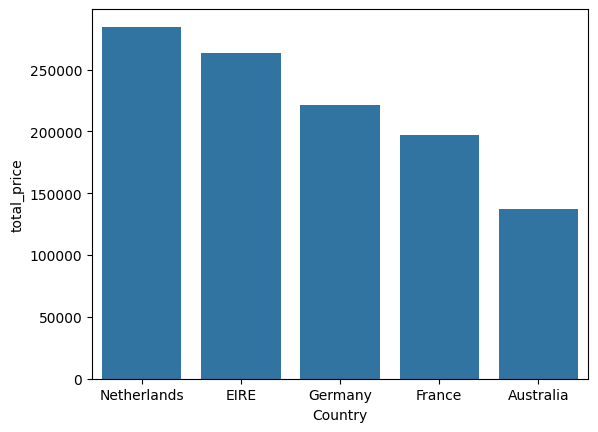

In [70]:

window_for_country = Window.orderBy(F.desc("total_price"))


country_lookup = spark_df.dropna(subset=["Country"])


country_grouped = (country_lookup.groupBy("Country")
 .agg(F.sum("total_price").alias("total_price"))
.sort("total_price", ascending=False)
)



country_grouped_ranked = country_grouped \
    .withColumn("ranked", F.rank().over(window_for_country))


pandas_df = country_grouped_ranked \
    .filter(F.col("ranked") > 1) \
    .limit(5) \
    .drop("ranked") \
    .toPandas()


sns.barplot(x="Country", y="total_price", data=pandas_df)